### 1.数据用是 LITS 肝脏数据集28个病例，使用PaddleSeg开发套件进行分割肝脏和肿瘤

In [ ]:
#安装 nii处理工具  SimpleITK 和分割工具paddleSeg
!pip install SimpleITK
!pip install paddleseg

Looking in indexes: https://mirror.baidu.com/pypi/simple/
Looking in indexes: https://mirror.baidu.com/pypi/simple/


In [ ]:
%cd /home/aistudio/
#首次要运行
!unzip  -o /home/aistudio/data/data82420/traindata.zip -d work/

/home/aistudio


In [ ]:
#导入常用库
import SimpleITK as sitk
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import cv2

### 2.处理数据，因为数据集里面有些是全腹部的，但是要分割肝脏，所以把不存在肝脏标签的多余‘层’去掉。

In [ ]:

raw_dataset_path = 'work/traindata'
# 预处理后的数据集的输出路径
fixed_dataset_path = 'work/new_traindata'
if not os.path.exists(fixed_dataset_path):
    os.mkdir(fixed_dataset_path)
if os.path.exists(fixed_dataset_path):    # 创建保存目录
    os.makedirs(os.path.join(fixed_dataset_path,'data'))
    os.makedirs(os.path.join(fixed_dataset_path,'label'))

upper = 200
lower = -200
for ct_file in os.listdir(os.path.join(raw_dataset_path ,'data')):
    #读取origin
    ct = sitk.ReadImage(os.path.join(os.path.join(raw_dataset_path ,'data'), ct_file), sitk.sitkInt16)
    #转换成 numpy格式
    ct_array = sitk.GetArrayFromImage(ct)

    seg = sitk.ReadImage(os.path.join(os.path.join(raw_dataset_path ,'label'), ct_file.replace('volume', 'segmentation')),
                            sitk.sitkInt8)
    seg_array = sitk.GetArrayFromImage(seg)
    print("裁剪前:{}".format(ct.GetSize(), seg.GetSize()))
    

    # 将灰度值在阈值之外的截断掉
    ct_array[ct_array > upper] = upper
    ct_array[ct_array < lower] = lower

    # 找到肝脏区域开始和结束的slice
    z = np.any(seg_array, axis=(1, 2))
    start_slice, end_slice = np.where(z)[0][[0, -1]]

    ct_array = ct_array[start_slice:end_slice + 1, :, :]
    seg_array = seg_array[start_slice:end_slice + 1, :, :]

    new_ct = sitk.GetImageFromArray(ct_array)
    new_ct.SetDirection(ct.GetDirection())
    new_ct.SetOrigin(ct.GetOrigin())

    new_seg = sitk.GetImageFromArray(seg_array)
    new_seg.SetDirection(ct.GetDirection())
    new_seg.SetOrigin(ct.GetOrigin())
    print("裁剪后:{}".format(new_ct.GetSize(), new_seg.GetSize()))

    sitk.WriteImage(new_ct, os.path.join(os.path.join(fixed_dataset_path ,'data'), ct_file))
    sitk.WriteImage(new_seg,
                    os.path.join(os.path.join(fixed_dataset_path , 'label'), ct_file.replace('volume', 'segmentation')))



### 3. 把nii的数据保存为jpg格式

In [ ]:

data_path = 'work/new_traindata/data'
label_path = 'work/new_traindata/label'
count = 0
if not os.path.exists('/home/aistudio/work/newdata'):
    os.mkdir('/home/aistudio/work/newdata')
    os.makedirs(os.path.join('/home/aistudio/work/newdata','origin'))
    os.makedirs(os.path.join('/home/aistudio/work/newdata','label'))
for f in os.listdir(data_path):
    origin_path= os.path.join(data_path, f)
    seg_path = os.path.join(label_path,f).replace('volume','segmentation')
    origin_array = sitk.GetArrayFromImage(sitk.ReadImage(origin_path))
    seg_array = sitk.GetArrayFromImage(sitk.ReadImage(seg_path))
    for i in range(seg_array.shape[0]):
        seg_image = seg_array[i,:,:]
        seg_image = np.rot90(np.transpose(seg_image, (1,0)))
        origin_image = origin_array[i,:,:]
        origin_image = np.rot90(np.transpose(origin_image, (1,0)))
        cv2.imwrite('work/newdata/label/'+str(count) + '.png', seg_image)
        cv2.imwrite('work/newdata/origin/'+str(count) + '.jpg', origin_image)
        count += 1

print(count)

4522


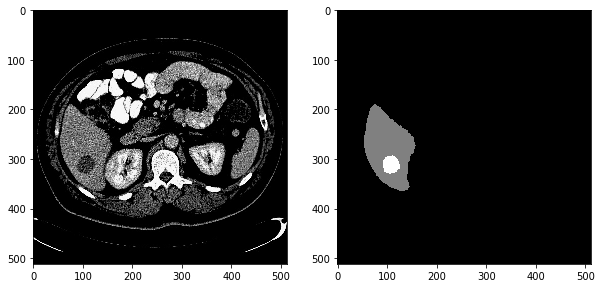

In [ ]:
image = cv2.imread('work/newdata/origin/51.jpg',0)
label = cv2.imread('work/newdata/label/51.png',0)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image,'gray')

plt.subplot(122)
plt.imshow(label, 'gray')
plt.show()

### 4.创建 train.txt, val.txt, test.txt文档

In [ ]:
random.seed(2021)
path_origin = '/home/aistudio/work/newdata/origin'
path_label = '/home/aistudio/work/newdata/label'
files = list(filter(lambda x: x.endswith('.jpg'), os.listdir(path_origin)))
random.shuffle(files)
rate = int(len(files) * 0.8)#训练集和测试集8：2
train_txt = open('/home/aistudio/work/newdata/train_list.txt','w')
val_txt = open('/home/aistudio/work/newdata/val_list.txt','w')
test_txt = open('/home/aistudio/work/newdata/test_list.txt','w')
for i,f in enumerate(files):
    image_path = os.path.join(path_origin, f)
    label_name = f.split('.')[0]+ '.png'
    label_path = os.path.join(path_label, label_name)
    if i < rate:
        train_txt.write(image_path + ' ' + label_path+ '\n')
    else:
        if i%2 :
            val_txt.write(image_path + ' ' + label_path+ '\n')
        else:
            test_txt.write(image_path + ' ' + label_path+ '\n')
train_txt.close()
val_txt.close()
test_txt.close()
print('完成')

完成


### 5.创建Transform  和DataSet

In [ ]:
import paddleseg.transforms as T
from paddleseg.datasets import OpticDiscSeg,Dataset

train_transforms = [
    #T.RandomHorizontalFlip(),# 水平翻转
    #T.RandomDistort(),# 随机扭曲
    #T.RandomRotation(max_rotation=10,im_padding_value=(0,0,0),label_padding_value=0),# 随机翻转
    #T.RandomBlur(),# 随机模糊
    #T.RandomScaleAspect(min_scale=0.8,aspect_ratio=0.5),# 随机缩放
    T.Resize(target_size=(512,512)),
    T.Normalize()

]
val_transforms = [
    T.Resize(target_size=(512,512)),
    T.Normalize()

]
dataset_root = '/home/aistudio/work/newdata'
train_path  = '/home/aistudio/work/newdata/train_list.txt'
val_path  = '/home/aistudio/work/newdata/val_list.txt'
test_path  = '/home/aistudio/work/newdata/test_list.txt'
# 构建训练集
train_dataset = Dataset(
    dataset_root=dataset_root,
    train_path=train_path,
    transforms=train_transforms,
    num_classes=3,
    mode='train'

                  )
#验证集
val_dataset = Dataset(
    dataset_root=dataset_root,
    val_path=val_path,
    transforms=val_transforms,
    num_classes=3,
    mode='val'

                  )

#测试集
test_dataset = Dataset(
    dataset_root=dataset_root,
    test_path=test_path,
    transforms=val_transforms,
    num_classes=3,
    mode='test'
            
                  )


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


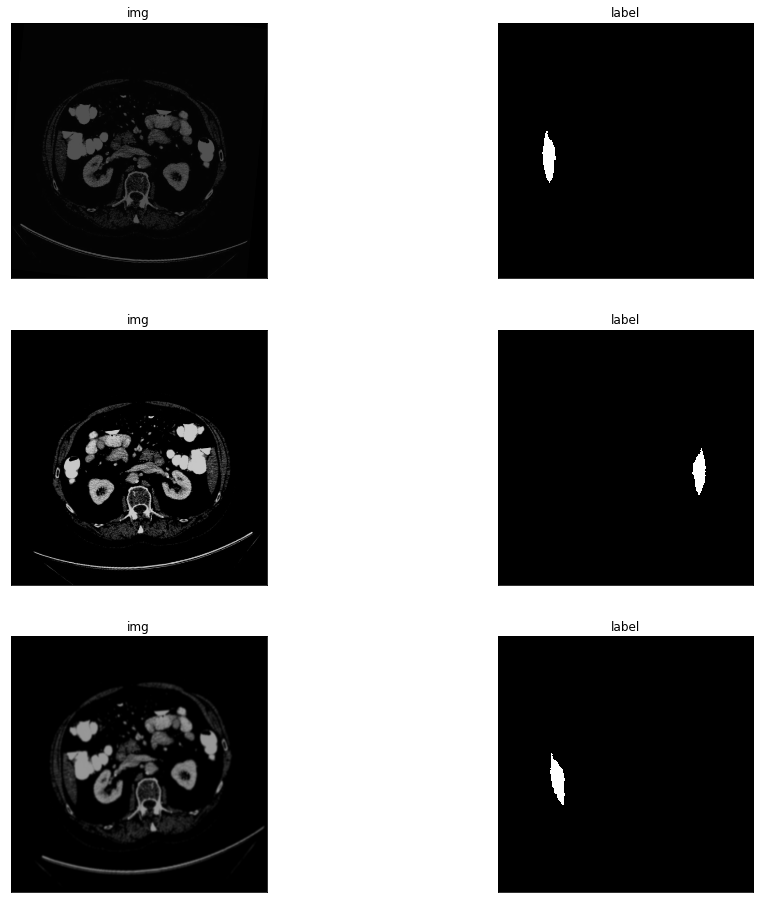

In [ ]:
#预览数据
#没有显示 ，在运行一次
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(16,16))
for i in range(1,6,2):
    img, label = train_dataset[131]
    img = np.transpose(img, (1,2,0))
    img = img*0.5 + 0.5
    plt.subplot(3,2,i),plt.imshow(img,'gray'),plt.title('img'),plt.xticks([]),plt.yticks([])
    plt.subplot(3,2,i+1),plt.imshow(label,'gray'),plt.title('label'),plt.xticks([]),plt.yticks([])
    plt.show

### 6.设置网络和 损失函数、优化器等

In [ ]:
# 导入模型
from paddleseg.models import U2Net
from paddleseg.models import UNet
num_classes=3
model = UNet(num_classes=num_classes)


In [ ]:
from paddleseg.models.losses import CrossEntropyLoss,DiceLoss
import paddle
# 设置学习率  
base_lr = 0.0045
#自己换学习率和优化器，能不能上高分
#lr = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=base_lr, T_max=1800, verbose=False)
optimizer = paddle.optimizer.Momentum(base_lr, parameters=model.parameters(), momentum=0.9, weight_decay=4.0e-5)
losses = {}
#自己尝试组合dice损失函数，会不会效果更好
losses['types'] = [CrossEntropyLoss()] 
losses['coef'] = [1]

### 7.开始训练

In [ ]:
from paddleseg.core import train
#查看文档自己补全
train(
    model = model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    save_dir='output/UNet8',
    iters=4000,
    batch_size=4,
    save_interval=200,
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
    )

2021-04-10 21:40:58 [INFO]	[TRAIN] epoch=1, iter=10/4000, loss=0.0110, lr=0.004500, batch_cost=0.2658, reader_cost=0.01159, ips=15.0462 samples/sec | ETA 00:17:40
2021-04-10 21:41:01 [INFO]	[TRAIN] epoch=1, iter=20/4000, loss=0.0108, lr=0.004500, batch_cost=0.2502, reader_cost=0.00011, ips=15.9848 samples/sec | ETA 00:16:35
2021-04-10 21:41:03 [INFO]	[TRAIN] epoch=1, iter=30/4000, loss=0.0098, lr=0.004500, batch_cost=0.2492, reader_cost=0.00009, ips=16.0538 samples/sec | ETA 00:16:29
2021-04-10 21:41:06 [INFO]	[TRAIN] epoch=1, iter=40/4000, loss=0.0117, lr=0.004500, batch_cost=0.2498, reader_cost=0.00009, ips=16.0130 samples/sec | ETA 00:16:29
2021-04-10 21:41:08 [INFO]	[TRAIN] epoch=1, iter=50/4000, loss=0.0086, lr=0.004500, batch_cost=0.2492, reader_cost=0.00008, ips=16.0485 samples/sec | ETA 00:16:24
2021-04-10 21:41:11 [INFO]	[TRAIN] epoch=1, iter=60/4000, loss=0.0117, lr=0.004500, batch_cost=0.2497, reader_cost=0.00009, ips=16.0223 samples/sec | ETA 00:16:23
2021-04-10 21:41:13 [I

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0169 - reader cost: 1.3714e-


2021-04-10 21:41:54 [INFO]	[EVAL] #Images=453 mIoU=0.8903 Acc=0.9957 Kappa=0.9661 
2021-04-10 21:41:54 [INFO]	[EVAL] Class IoU: 
[0.9959 0.9381 0.7368]
2021-04-10 21:41:54 [INFO]	[EVAL] Class Acc: 
[0.9984 0.9625 0.8567]
2021-04-10 21:41:55 [INFO]	[EVAL] The model with the best validation mIoU (0.8903) was saved at iter 200.
2021-04-10 21:41:58 [INFO]	[TRAIN] epoch=1, iter=210/4000, loss=0.0106, lr=0.004500, batch_cost=0.2509, reader_cost=0.00009, ips=15.9404 samples/sec | ETA 00:15:51
2021-04-10 21:42:00 [INFO]	[TRAIN] epoch=1, iter=220/4000, loss=0.0102, lr=0.004500, batch_cost=0.2515, reader_cost=0.00008, ips=15.9074 samples/sec | ETA 00:15:50
2021-04-10 21:42:03 [INFO]	[TRAIN] epoch=1, iter=230/4000, loss=0.0095, lr=0.004500, batch_cost=0.2508, reader_cost=0.00008, ips=15.9489 samples/sec | ETA 00:15:45
2021-04-10 21:42:05 [INFO]	[TRAIN] epoch=1, iter=240/4000, loss=0.0099, lr=0.004500, batch_cost=0.2510, reader_cost=0.00007, ips=15.9340 samples/sec | ETA 00:15:43
2021-04-10 21:42:

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.0979e-


2021-04-10 21:42:53 [INFO]	[EVAL] #Images=453 mIoU=0.8951 Acc=0.9958 Kappa=0.9670 
2021-04-10 21:42:53 [INFO]	[EVAL] Class IoU: 
[0.9961 0.9394 0.7497]
2021-04-10 21:42:53 [INFO]	[EVAL] Class Acc: 
[0.9982 0.967  0.8451]
2021-04-10 21:42:55 [INFO]	[EVAL] The model with the best validation mIoU (0.8951) was saved at iter 400.
2021-04-10 21:42:57 [INFO]	[TRAIN] epoch=1, iter=410/4000, loss=0.0085, lr=0.004500, batch_cost=0.2514, reader_cost=0.00009, ips=15.9106 samples/sec | ETA 00:15:02
2021-04-10 21:43:00 [INFO]	[TRAIN] epoch=1, iter=420/4000, loss=0.0097, lr=0.004500, batch_cost=0.2508, reader_cost=0.00009, ips=15.9467 samples/sec | ETA 00:14:57
2021-04-10 21:43:02 [INFO]	[TRAIN] epoch=1, iter=430/4000, loss=0.0088, lr=0.004500, batch_cost=0.2508, reader_cost=0.00006, ips=15.9458 samples/sec | ETA 00:14:55
2021-04-10 21:43:05 [INFO]	[TRAIN] epoch=1, iter=440/4000, loss=0.0082, lr=0.004500, batch_cost=0.2513, reader_cost=0.00009, ips=15.9169 samples/sec | ETA 00:14:54
2021-04-10 21:43:

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.0207e-0


2021-04-10 21:43:53 [INFO]	[EVAL] #Images=453 mIoU=0.8837 Acc=0.9956 Kappa=0.9657 
2021-04-10 21:43:53 [INFO]	[EVAL] Class IoU: 
[0.996  0.9376 0.7176]
2021-04-10 21:43:53 [INFO]	[EVAL] Class Acc: 
[0.9986 0.9617 0.7694]
2021-04-10 21:43:54 [INFO]	[EVAL] The model with the best validation mIoU (0.8951) was saved at iter 400.
2021-04-10 21:43:57 [INFO]	[TRAIN] epoch=1, iter=610/4000, loss=0.0107, lr=0.004500, batch_cost=0.2514, reader_cost=0.00009, ips=15.9091 samples/sec | ETA 00:14:12
2021-04-10 21:43:59 [INFO]	[TRAIN] epoch=1, iter=620/4000, loss=0.0113, lr=0.004500, batch_cost=0.2524, reader_cost=0.00008, ips=15.8474 samples/sec | ETA 00:14:13
2021-04-10 21:44:02 [INFO]	[TRAIN] epoch=1, iter=630/4000, loss=0.0105, lr=0.004500, batch_cost=0.2519, reader_cost=0.00007, ips=15.8800 samples/sec | ETA 00:14:08
2021-04-10 21:44:04 [INFO]	[TRAIN] epoch=1, iter=640/4000, loss=0.0110, lr=0.004500, batch_cost=0.2519, reader_cost=0.00006, ips=15.8781 samples/sec | ETA 00:14:06
2021-04-10 21:44:

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.0772e-


2021-04-10 21:44:52 [INFO]	[EVAL] #Images=453 mIoU=0.8888 Acc=0.9955 Kappa=0.9648 
2021-04-10 21:44:52 [INFO]	[EVAL] Class IoU: 
[0.9958 0.9354 0.7353]
2021-04-10 21:44:52 [INFO]	[EVAL] Class Acc: 
[0.998  0.9626 0.9141]
2021-04-10 21:44:53 [INFO]	[EVAL] The model with the best validation mIoU (0.8951) was saved at iter 400.
2021-04-10 21:44:56 [INFO]	[TRAIN] epoch=1, iter=810/4000, loss=0.0130, lr=0.004500, batch_cost=0.2523, reader_cost=0.00008, ips=15.8528 samples/sec | ETA 00:13:24
2021-04-10 21:44:58 [INFO]	[TRAIN] epoch=1, iter=820/4000, loss=0.0112, lr=0.004500, batch_cost=0.2521, reader_cost=0.00008, ips=15.8674 samples/sec | ETA 00:13:21
2021-04-10 21:45:01 [INFO]	[TRAIN] epoch=1, iter=830/4000, loss=0.0095, lr=0.004500, batch_cost=0.2517, reader_cost=0.00008, ips=15.8900 samples/sec | ETA 00:13:17
2021-04-10 21:45:03 [INFO]	[TRAIN] epoch=1, iter=840/4000, loss=0.0126, lr=0.004500, batch_cost=0.2514, reader_cost=0.00007, ips=15.9080 samples/sec | ETA 00:13:14
2021-04-10 21:45:

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.0043e-


2021-04-10 21:45:52 [INFO]	[EVAL] #Images=453 mIoU=0.8966 Acc=0.9959 Kappa=0.9679 
2021-04-10 21:45:52 [INFO]	[EVAL] Class IoU: 
[0.9962 0.9413 0.7524]
2021-04-10 21:45:52 [INFO]	[EVAL] Class Acc: 
[0.9983 0.967  0.8515]
2021-04-10 21:45:53 [INFO]	[EVAL] The model with the best validation mIoU (0.8966) was saved at iter 1000.
2021-04-10 21:45:56 [INFO]	[TRAIN] epoch=2, iter=1010/4000, loss=0.0084, lr=0.004500, batch_cost=0.2514, reader_cost=0.00008, ips=15.9119 samples/sec | ETA 00:12:31
2021-04-10 21:45:58 [INFO]	[TRAIN] epoch=2, iter=1020/4000, loss=0.0099, lr=0.004500, batch_cost=0.2523, reader_cost=0.00011, ips=15.8520 samples/sec | ETA 00:12:31
2021-04-10 21:46:01 [INFO]	[TRAIN] epoch=2, iter=1030/4000, loss=0.0097, lr=0.004500, batch_cost=0.2527, reader_cost=0.00007, ips=15.8301 samples/sec | ETA 00:12:30
2021-04-10 21:46:03 [INFO]	[TRAIN] epoch=2, iter=1040/4000, loss=0.0107, lr=0.004500, batch_cost=0.2517, reader_cost=0.00007, ips=15.8918 samples/sec | ETA 00:12:25
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.0614e-


2021-04-10 21:46:51 [INFO]	[EVAL] #Images=453 mIoU=0.8895 Acc=0.9953 Kappa=0.9638 
2021-04-10 21:46:51 [INFO]	[EVAL] Class IoU: 
[0.9956 0.9342 0.7386]
2021-04-10 21:46:51 [INFO]	[EVAL] Class Acc: 
[0.9989 0.9522 0.8309]
2021-04-10 21:46:52 [INFO]	[EVAL] The model with the best validation mIoU (0.8966) was saved at iter 1000.
2021-04-10 21:46:55 [INFO]	[TRAIN] epoch=2, iter=1210/4000, loss=0.0078, lr=0.004500, batch_cost=0.2523, reader_cost=0.00009, ips=15.8557 samples/sec | ETA 00:11:43
2021-04-10 21:46:57 [INFO]	[TRAIN] epoch=2, iter=1220/4000, loss=0.0070, lr=0.004500, batch_cost=0.2526, reader_cost=0.00012, ips=15.8324 samples/sec | ETA 00:11:42
2021-04-10 21:47:00 [INFO]	[TRAIN] epoch=2, iter=1230/4000, loss=0.0121, lr=0.004500, batch_cost=0.2523, reader_cost=0.00007, ips=15.8549 samples/sec | ETA 00:11:38
2021-04-10 21:47:02 [INFO]	[TRAIN] epoch=2, iter=1240/4000, loss=0.0090, lr=0.004500, batch_cost=0.2523, reader_cost=0.00012, ips=15.8533 samples/sec | ETA 00:11:36
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.1371e-


2021-04-10 21:47:51 [INFO]	[EVAL] #Images=453 mIoU=0.8998 Acc=0.9960 Kappa=0.9686 
2021-04-10 21:47:51 [INFO]	[EVAL] Class IoU: 
[0.9963 0.9423 0.7608]
2021-04-10 21:47:51 [INFO]	[EVAL] Class Acc: 
[0.9984 0.9676 0.8427]
2021-04-10 21:47:52 [INFO]	[EVAL] The model with the best validation mIoU (0.8998) was saved at iter 1400.
2021-04-10 21:47:55 [INFO]	[TRAIN] epoch=2, iter=1410/4000, loss=0.0092, lr=0.004500, batch_cost=0.2519, reader_cost=0.00008, ips=15.8794 samples/sec | ETA 00:10:52
2021-04-10 21:47:57 [INFO]	[TRAIN] epoch=2, iter=1420/4000, loss=0.0080, lr=0.004500, batch_cost=0.2521, reader_cost=0.00008, ips=15.8657 samples/sec | ETA 00:10:50
2021-04-10 21:48:00 [INFO]	[TRAIN] epoch=2, iter=1430/4000, loss=0.0086, lr=0.004500, batch_cost=0.2518, reader_cost=0.00008, ips=15.8856 samples/sec | ETA 00:10:47
2021-04-10 21:48:02 [INFO]	[TRAIN] epoch=2, iter=1440/4000, loss=0.0082, lr=0.004500, batch_cost=0.2529, reader_cost=0.00008, ips=15.8152 samples/sec | ETA 00:10:47
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.1873e-


2021-04-10 21:48:51 [INFO]	[EVAL] #Images=453 mIoU=0.8950 Acc=0.9959 Kappa=0.9677 
2021-04-10 21:48:51 [INFO]	[EVAL] Class IoU: 
[0.9961 0.9407 0.7483]
2021-04-10 21:48:51 [INFO]	[EVAL] Class Acc: 
[0.9987 0.9613 0.8477]
2021-04-10 21:48:51 [INFO]	[EVAL] The model with the best validation mIoU (0.8998) was saved at iter 1400.
2021-04-10 21:48:54 [INFO]	[TRAIN] epoch=2, iter=1610/4000, loss=0.0076, lr=0.004500, batch_cost=0.2523, reader_cost=0.00009, ips=15.8541 samples/sec | ETA 00:10:02
2021-04-10 21:48:57 [INFO]	[TRAIN] epoch=2, iter=1620/4000, loss=0.0098, lr=0.004500, batch_cost=0.2517, reader_cost=0.00006, ips=15.8933 samples/sec | ETA 00:09:58
2021-04-10 21:48:59 [INFO]	[TRAIN] epoch=2, iter=1630/4000, loss=0.0096, lr=0.004500, batch_cost=0.2522, reader_cost=0.00008, ips=15.8581 samples/sec | ETA 00:09:57
2021-04-10 21:49:02 [INFO]	[TRAIN] epoch=2, iter=1640/4000, loss=0.0075, lr=0.004500, batch_cost=0.2520, reader_cost=0.00010, ips=15.8753 samples/sec | ETA 00:09:54
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 9.8438e-0


2021-04-10 21:49:50 [INFO]	[EVAL] #Images=453 mIoU=0.8963 Acc=0.9960 Kappa=0.9686 
2021-04-10 21:49:50 [INFO]	[EVAL] Class IoU: 
[0.9963 0.9425 0.7501]
2021-04-10 21:49:50 [INFO]	[EVAL] Class Acc: 
[0.9986 0.9647 0.8367]
2021-04-10 21:49:51 [INFO]	[EVAL] The model with the best validation mIoU (0.8998) was saved at iter 1400.
2021-04-10 21:49:53 [INFO]	[TRAIN] epoch=3, iter=1810/4000, loss=0.0088, lr=0.004500, batch_cost=0.2622, reader_cost=0.00797, ips=15.2543 samples/sec | ETA 00:09:34
2021-04-10 21:49:56 [INFO]	[TRAIN] epoch=3, iter=1820/4000, loss=0.0081, lr=0.004500, batch_cost=0.2532, reader_cost=0.00009, ips=15.7963 samples/sec | ETA 00:09:12
2021-04-10 21:49:58 [INFO]	[TRAIN] epoch=3, iter=1830/4000, loss=0.0077, lr=0.004500, batch_cost=0.2527, reader_cost=0.00008, ips=15.8272 samples/sec | ETA 00:09:08
2021-04-10 21:50:01 [INFO]	[TRAIN] epoch=3, iter=1840/4000, loss=0.0087, lr=0.004500, batch_cost=0.2523, reader_cost=0.00008, ips=15.8536 samples/sec | ETA 00:09:04
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 9.4768e-


2021-04-10 21:50:49 [INFO]	[EVAL] #Images=453 mIoU=0.9035 Acc=0.9961 Kappa=0.9688 
2021-04-10 21:50:49 [INFO]	[EVAL] Class IoU: 
[0.9963 0.9424 0.7719]
2021-04-10 21:50:49 [INFO]	[EVAL] Class Acc: 
[0.9978 0.9734 0.9073]
2021-04-10 21:50:51 [INFO]	[EVAL] The model with the best validation mIoU (0.9035) was saved at iter 2000.
2021-04-10 21:50:53 [INFO]	[TRAIN] epoch=3, iter=2010/4000, loss=0.0105, lr=0.004500, batch_cost=0.2519, reader_cost=0.00009, ips=15.8807 samples/sec | ETA 00:08:21
2021-04-10 21:50:56 [INFO]	[TRAIN] epoch=3, iter=2020/4000, loss=0.0096, lr=0.004500, batch_cost=0.2523, reader_cost=0.00011, ips=15.8526 samples/sec | ETA 00:08:19
2021-04-10 21:50:58 [INFO]	[TRAIN] epoch=3, iter=2030/4000, loss=0.0071, lr=0.004500, batch_cost=0.2517, reader_cost=0.00008, ips=15.8912 samples/sec | ETA 00:08:15
2021-04-10 21:51:01 [INFO]	[TRAIN] epoch=3, iter=2040/4000, loss=0.0092, lr=0.004500, batch_cost=0.2522, reader_cost=0.00009, ips=15.8579 samples/sec | ETA 00:08:14
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.3148e-


2021-04-10 21:51:49 [INFO]	[EVAL] #Images=453 mIoU=0.9039 Acc=0.9961 Kappa=0.9690 
2021-04-10 21:51:49 [INFO]	[EVAL] Class IoU: 
[0.9963 0.9429 0.7725]
2021-04-10 21:51:49 [INFO]	[EVAL] Class Acc: 
[0.9978 0.976  0.8511]
2021-04-10 21:51:51 [INFO]	[EVAL] The model with the best validation mIoU (0.9039) was saved at iter 2200.
2021-04-10 21:51:53 [INFO]	[TRAIN] epoch=3, iter=2210/4000, loss=0.0084, lr=0.004500, batch_cost=0.2522, reader_cost=0.00009, ips=15.8587 samples/sec | ETA 00:07:31
2021-04-10 21:51:56 [INFO]	[TRAIN] epoch=3, iter=2220/4000, loss=0.0076, lr=0.004500, batch_cost=0.2524, reader_cost=0.00012, ips=15.8497 samples/sec | ETA 00:07:29
2021-04-10 21:51:58 [INFO]	[TRAIN] epoch=3, iter=2230/4000, loss=0.0096, lr=0.004500, batch_cost=0.2528, reader_cost=0.00015, ips=15.8240 samples/sec | ETA 00:07:27
2021-04-10 21:52:01 [INFO]	[TRAIN] epoch=3, iter=2240/4000, loss=0.0080, lr=0.004500, batch_cost=0.2521, reader_cost=0.00008, ips=15.8650 samples/sec | ETA 00:07:23
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.1747e-0


2021-04-10 21:52:49 [INFO]	[EVAL] #Images=453 mIoU=0.9057 Acc=0.9962 Kappa=0.9703 
2021-04-10 21:52:49 [INFO]	[EVAL] Class IoU: 
[0.9965 0.9451 0.7755]
2021-04-10 21:52:49 [INFO]	[EVAL] Class Acc: 
[0.9983 0.9711 0.8686]
2021-04-10 21:52:50 [INFO]	[EVAL] The model with the best validation mIoU (0.9057) was saved at iter 2400.
2021-04-10 21:52:53 [INFO]	[TRAIN] epoch=3, iter=2410/4000, loss=0.0095, lr=0.004500, batch_cost=0.2521, reader_cost=0.00008, ips=15.8641 samples/sec | ETA 00:06:40
2021-04-10 21:52:55 [INFO]	[TRAIN] epoch=3, iter=2420/4000, loss=0.0075, lr=0.004500, batch_cost=0.2519, reader_cost=0.00007, ips=15.8810 samples/sec | ETA 00:06:37
2021-04-10 21:52:58 [INFO]	[TRAIN] epoch=3, iter=2430/4000, loss=0.0068, lr=0.004500, batch_cost=0.2520, reader_cost=0.00010, ips=15.8700 samples/sec | ETA 00:06:35
2021-04-10 21:53:00 [INFO]	[TRAIN] epoch=3, iter=2440/4000, loss=0.0076, lr=0.004500, batch_cost=0.2531, reader_cost=0.00010, ips=15.8019 samples/sec | ETA 00:06:34
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.0445e-


2021-04-10 21:53:49 [INFO]	[EVAL] #Images=453 mIoU=0.9032 Acc=0.9962 Kappa=0.9702 
2021-04-10 21:53:49 [INFO]	[EVAL] Class IoU: 
[0.9965 0.9451 0.7681]
2021-04-10 21:53:49 [INFO]	[EVAL] Class Acc: 
[0.9985 0.9685 0.854 ]
2021-04-10 21:53:50 [INFO]	[EVAL] The model with the best validation mIoU (0.9057) was saved at iter 2400.
2021-04-10 21:53:52 [INFO]	[TRAIN] epoch=3, iter=2610/4000, loss=0.0075, lr=0.004500, batch_cost=0.2524, reader_cost=0.00009, ips=15.8481 samples/sec | ETA 00:05:50
2021-04-10 21:53:55 [INFO]	[TRAIN] epoch=3, iter=2620/4000, loss=0.0075, lr=0.004500, batch_cost=0.2525, reader_cost=0.00008, ips=15.8409 samples/sec | ETA 00:05:48
2021-04-10 21:53:57 [INFO]	[TRAIN] epoch=3, iter=2630/4000, loss=0.0070, lr=0.004500, batch_cost=0.2520, reader_cost=0.00008, ips=15.8730 samples/sec | ETA 00:05:45
2021-04-10 21:54:00 [INFO]	[TRAIN] epoch=3, iter=2640/4000, loss=0.0087, lr=0.004500, batch_cost=0.2532, reader_cost=0.00010, ips=15.8000 samples/sec | ETA 00:05:44
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.0804e-0


2021-04-10 21:54:48 [INFO]	[EVAL] #Images=453 mIoU=0.8939 Acc=0.9961 Kappa=0.9697 
2021-04-10 21:54:48 [INFO]	[EVAL] Class IoU: 
[0.9965 0.9446 0.7407]
2021-04-10 21:54:48 [INFO]	[EVAL] Class Acc: 
[0.9986 0.9684 0.8055]
2021-04-10 21:54:49 [INFO]	[EVAL] The model with the best validation mIoU (0.9057) was saved at iter 2400.
2021-04-10 21:54:52 [INFO]	[TRAIN] epoch=4, iter=2810/4000, loss=0.0104, lr=0.004500, batch_cost=0.2518, reader_cost=0.00008, ips=15.8836 samples/sec | ETA 00:04:59
2021-04-10 21:54:54 [INFO]	[TRAIN] epoch=4, iter=2820/4000, loss=0.0098, lr=0.004500, batch_cost=0.2521, reader_cost=0.00008, ips=15.8665 samples/sec | ETA 00:04:57
2021-04-10 21:54:57 [INFO]	[TRAIN] epoch=4, iter=2830/4000, loss=0.0086, lr=0.004500, batch_cost=0.2524, reader_cost=0.00006, ips=15.8504 samples/sec | ETA 00:04:55
2021-04-10 21:54:59 [INFO]	[TRAIN] epoch=4, iter=2840/4000, loss=0.0093, lr=0.004500, batch_cost=0.2521, reader_cost=0.00009, ips=15.8665 samples/sec | ETA 00:04:52
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.0499e-


2021-04-10 21:55:47 [INFO]	[EVAL] #Images=453 mIoU=0.9050 Acc=0.9962 Kappa=0.9704 
2021-04-10 21:55:47 [INFO]	[EVAL] Class IoU: 
[0.9965 0.9455 0.7729]
2021-04-10 21:55:47 [INFO]	[EVAL] Class Acc: 
[0.9987 0.9666 0.8513]
2021-04-10 21:55:48 [INFO]	[EVAL] The model with the best validation mIoU (0.9057) was saved at iter 2400.
2021-04-10 21:55:51 [INFO]	[TRAIN] epoch=4, iter=3010/4000, loss=0.0092, lr=0.004500, batch_cost=0.2522, reader_cost=0.00009, ips=15.8617 samples/sec | ETA 00:04:09
2021-04-10 21:55:53 [INFO]	[TRAIN] epoch=4, iter=3020/4000, loss=0.0082, lr=0.004500, batch_cost=0.2522, reader_cost=0.00008, ips=15.8600 samples/sec | ETA 00:04:07
2021-04-10 21:55:56 [INFO]	[TRAIN] epoch=4, iter=3030/4000, loss=0.0097, lr=0.004500, batch_cost=0.2520, reader_cost=0.00006, ips=15.8734 samples/sec | ETA 00:04:04
2021-04-10 21:55:58 [INFO]	[TRAIN] epoch=4, iter=3040/4000, loss=0.0081, lr=0.004500, batch_cost=0.2521, reader_cost=0.00008, ips=15.8698 samples/sec | ETA 00:04:01
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.2515e-0


2021-04-10 21:56:47 [INFO]	[EVAL] #Images=453 mIoU=0.9021 Acc=0.9963 Kappa=0.9707 
2021-04-10 21:56:47 [INFO]	[EVAL] Class IoU: 
[0.9965 0.9458 0.7638]
2021-04-10 21:56:47 [INFO]	[EVAL] Class Acc: 
[0.9986 0.9655 0.9123]
2021-04-10 21:56:48 [INFO]	[EVAL] The model with the best validation mIoU (0.9057) was saved at iter 2400.
2021-04-10 21:56:50 [INFO]	[TRAIN] epoch=4, iter=3210/4000, loss=0.0068, lr=0.004500, batch_cost=0.2519, reader_cost=0.00008, ips=15.8774 samples/sec | ETA 00:03:19
2021-04-10 21:56:53 [INFO]	[TRAIN] epoch=4, iter=3220/4000, loss=0.0084, lr=0.004500, batch_cost=0.2520, reader_cost=0.00008, ips=15.8701 samples/sec | ETA 00:03:16
2021-04-10 21:56:55 [INFO]	[TRAIN] epoch=4, iter=3230/4000, loss=0.0087, lr=0.004500, batch_cost=0.2524, reader_cost=0.00009, ips=15.8493 samples/sec | ETA 00:03:14
2021-04-10 21:56:58 [INFO]	[TRAIN] epoch=4, iter=3240/4000, loss=0.0089, lr=0.004500, batch_cost=0.2524, reader_cost=0.00010, ips=15.8450 samples/sec | ETA 00:03:11
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.0464e-


2021-04-10 21:57:46 [INFO]	[EVAL] #Images=453 mIoU=0.9098 Acc=0.9964 Kappa=0.9719 
2021-04-10 21:57:46 [INFO]	[EVAL] Class IoU: 
[0.9967 0.948  0.7847]
2021-04-10 21:57:46 [INFO]	[EVAL] Class Acc: 
[0.9984 0.9706 0.9123]
2021-04-10 21:57:47 [INFO]	[EVAL] The model with the best validation mIoU (0.9098) was saved at iter 3400.
2021-04-10 21:57:50 [INFO]	[TRAIN] epoch=4, iter=3410/4000, loss=0.0076, lr=0.004500, batch_cost=0.2519, reader_cost=0.00008, ips=15.8762 samples/sec | ETA 00:02:28
2021-04-10 21:57:53 [INFO]	[TRAIN] epoch=4, iter=3420/4000, loss=0.0072, lr=0.004500, batch_cost=0.2521, reader_cost=0.00008, ips=15.8692 samples/sec | ETA 00:02:26
2021-04-10 21:57:55 [INFO]	[TRAIN] epoch=4, iter=3430/4000, loss=0.0085, lr=0.004500, batch_cost=0.2520, reader_cost=0.00008, ips=15.8717 samples/sec | ETA 00:02:23
2021-04-10 21:57:58 [INFO]	[TRAIN] epoch=4, iter=3440/4000, loss=0.0102, lr=0.004500, batch_cost=0.2527, reader_cost=0.00008, ips=15.8300 samples/sec | ETA 00:02:21
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 9.7317e-


2021-04-10 21:58:46 [INFO]	[EVAL] #Images=453 mIoU=0.9034 Acc=0.9962 Kappa=0.9701 
2021-04-10 21:58:46 [INFO]	[EVAL] Class IoU: 
[0.9964 0.945  0.7687]
2021-04-10 21:58:46 [INFO]	[EVAL] Class Acc: 
[0.9983 0.9727 0.8261]
2021-04-10 21:58:47 [INFO]	[EVAL] The model with the best validation mIoU (0.9098) was saved at iter 3400.
2021-04-10 21:58:49 [INFO]	[TRAIN] epoch=4, iter=3610/4000, loss=0.0085, lr=0.004500, batch_cost=0.2520, reader_cost=0.00010, ips=15.8721 samples/sec | ETA 00:01:38
2021-04-10 21:58:52 [INFO]	[TRAIN] epoch=5, iter=3620/4000, loss=0.0094, lr=0.004500, batch_cost=0.2588, reader_cost=0.00690, ips=15.4531 samples/sec | ETA 00:01:38
2021-04-10 21:58:54 [INFO]	[TRAIN] epoch=5, iter=3630/4000, loss=0.0081, lr=0.004500, batch_cost=0.2531, reader_cost=0.00010, ips=15.8032 samples/sec | ETA 00:01:33
2021-04-10 21:58:57 [INFO]	[TRAIN] epoch=5, iter=3640/4000, loss=0.0066, lr=0.004500, batch_cost=0.2529, reader_cost=0.00010, ips=15.8168 samples/sec | ETA 00:01:31
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 9.6953e-


2021-04-10 21:59:45 [INFO]	[EVAL] #Images=453 mIoU=0.9129 Acc=0.9964 Kappa=0.9719 
2021-04-10 21:59:45 [INFO]	[EVAL] Class IoU: 
[0.9966 0.9479 0.7943]
2021-04-10 21:59:45 [INFO]	[EVAL] Class Acc: 
[0.9981 0.9756 0.8929]
2021-04-10 21:59:47 [INFO]	[EVAL] The model with the best validation mIoU (0.9129) was saved at iter 3800.
2021-04-10 21:59:49 [INFO]	[TRAIN] epoch=5, iter=3810/4000, loss=0.0077, lr=0.004500, batch_cost=0.2523, reader_cost=0.00009, ips=15.8519 samples/sec | ETA 00:00:47
2021-04-10 21:59:52 [INFO]	[TRAIN] epoch=5, iter=3820/4000, loss=0.0080, lr=0.004500, batch_cost=0.2526, reader_cost=0.00010, ips=15.8360 samples/sec | ETA 00:00:45
2021-04-10 21:59:54 [INFO]	[TRAIN] epoch=5, iter=3830/4000, loss=0.0074, lr=0.004500, batch_cost=0.2527, reader_cost=0.00008, ips=15.8315 samples/sec | ETA 00:00:42
2021-04-10 21:59:57 [INFO]	[TRAIN] epoch=5, iter=3840/4000, loss=0.0066, lr=0.004500, batch_cost=0.2519, reader_cost=0.00008, ips=15.8785 samples/sec | ETA 00:00:40
2021-04-10 2

453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0170 - reader cost: 1.0176e-


2021-04-10 22:00:45 [INFO]	[EVAL] #Images=453 mIoU=0.9054 Acc=0.9961 Kappa=0.9692 
2021-04-10 22:00:45 [INFO]	[EVAL] Class IoU: 
[0.9963 0.9435 0.7764]
2021-04-10 22:00:45 [INFO]	[EVAL] Class Acc: 
[0.9987 0.9633 0.8873]
2021-04-10 22:00:46 [INFO]	[EVAL] The model with the best validation mIoU (0.9129) was saved at iter 3800.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
Customize Function has been applied to <class 'paddle.nn.layer.norm.SyncBatchNorm'>
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
Total Flops: 124455223296     Total Params: 13404931


### 8.0评估测试集

In [ ]:

from paddleseg.core import evaluate
model = UNet(num_classes=3)
#换自己保存的模型文件
model_path = 'output/UNet8/best_model/model.pdparams'
para_state_dict = paddle.load(model_path)
model.set_dict(para_state_dict)
evaluate(model,val_dataset)

2021-04-10 22:08:08 [INFO]	Start evaluating (total_samples=453, total_iters=453)...


  7/453 [..............................] - ETA: 9s - batch_cost: 0.0208 - reader cost: 0.0035 453/453 [==============================] - 8s 17ms/step - batch_cost: 0.0169 - reader cost: 1.0080e-0


2021-04-10 22:08:16 [INFO]	[EVAL] #Images=453 mIoU=0.9129 Acc=0.9964 Kappa=0.9719 
2021-04-10 22:08:16 [INFO]	[EVAL] Class IoU: 
[0.9966 0.9479 0.7943]
2021-04-10 22:08:16 [INFO]	[EVAL] Class Acc: 
[0.9981 0.9756 0.8929]


(0.91293055, 0.996447)

In [ ]:

from paddleseg.core import predict
transforms = T.Compose([
    T.Resize(target_size=(512, 512)),
    T.Normalize()
])

model = UNet(num_classes=3)
#生成图片列表
image_list = []
with open('/home/aistudio/work/newdata/test_list.txt' ,'r') as f:
    for line in f.readlines():
        image_list.append(line.split()[0])

predict(
        model,
        #换自己保存的模型文件
        model_path = 'output/UNet8/best_model/model.pdparams',
        transforms=transforms,
        image_list=image_list,
        save_dir='/home/aistudio/output/results',
    )

2021-04-10 22:09:50 [INFO]	Loading pretrained model from output/UNet8/best_model/model.pdparams
2021-04-10 22:09:50 [INFO]	There are 112/112 variables loaded into UNet.
2021-04-10 22:09:50 [INFO]	Start to predict...


452/452 [==============================] - 19s 41ms/ste


### 9.预览分割结果

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


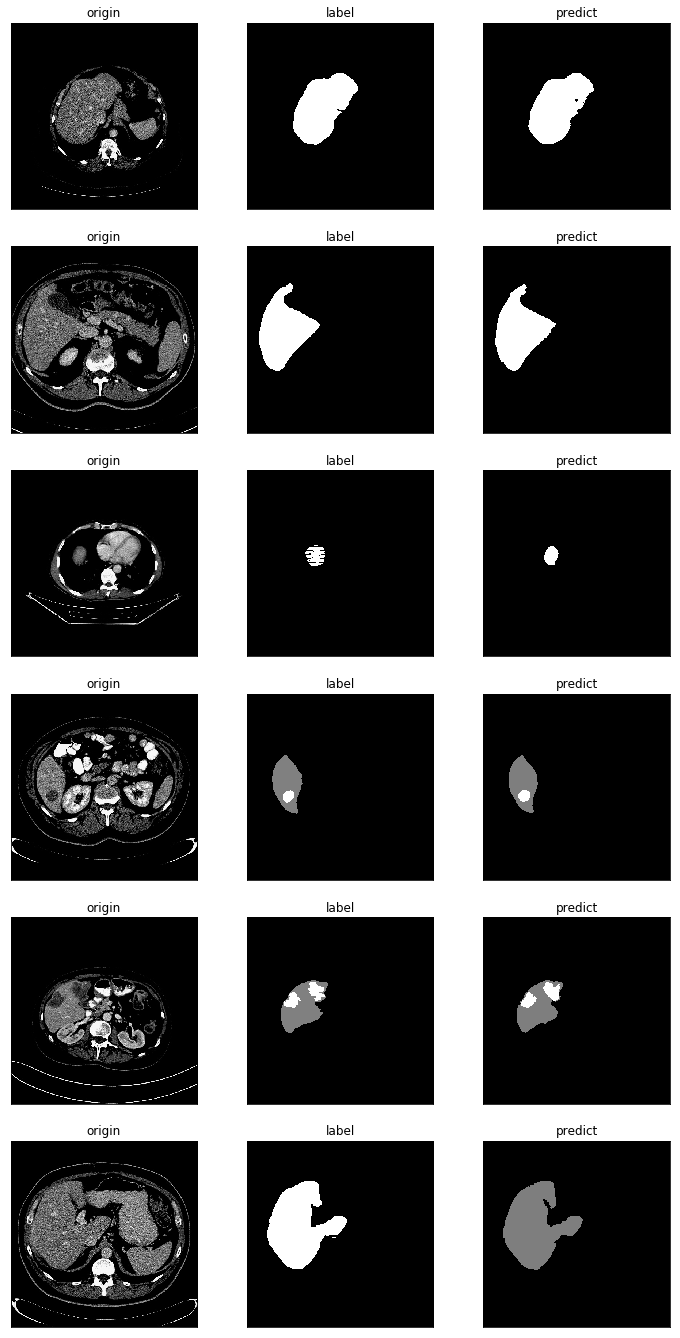

In [ ]:
num = 6
img_list = random.sample(image_list, num)
pre_path = 'output/results/pseudo_color_prediction'
plt.figure(figsize=(12,num*4))
index = 1
for i in range(len(img_list)):
    plt.subplot(num,3,index)
    img_origin = cv2.imread(img_list[i],0)
    plt.title('origin')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_origin,'gray')

    plt.subplot(num,3,index+1)
    label_path = (img_list[i].replace('origin', 'label')).replace('jpg','png')
    img_label = cv2.imread(label_path,0)
    plt.title('label')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_label, 'gray')

    plt.subplot(num,3,index+2)
    predict_path = os.path.join(pre_path, os.path.basename(label_path))
    img_pre = cv2.imread(predict_path,0)
    plt.title('predict')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_pre, 'gray')

    index += 3

plt.show()



